# 醤油の色と味分析で日本各地を巡る旅 食品成分と味覚モデルで味わう旅グルメ



5'-リボヌクレオチド二ナトリウム(disodium 5-ribonucleotide)は、呈味性ヌクレオチドの一種。核酸系調味料、5′-リボヌクレオタイドナトリウムとも呼ばれ、主にうま味調味料やスープの配合成分として用いられる。

イノシン酸のナトリウム塩であるイノシン酸ナトリウムと、グアニル酸のナトリウム塩であるグアニル酸ナトリウムを主成分とした混合物である。両成分を略してI+Gと表記される場合もある。白色の粉末として得られる。無臭。

5-イノシン酸二ナトリウム塩(5'-IMP・2Na)は鰹節の旨味成分であり、5-グアニル酸二ナトリウム塩(5'-GMP・2Na)はシイタケの旨味成分である。リン酸の結合位置が違う2-、3-、5-があることが知られているが、調味料として有用なのは5-だけである。

## 「しょうゆの標準色」を描画するコード例

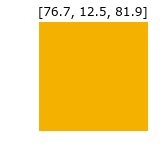

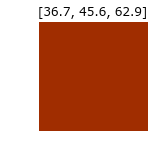

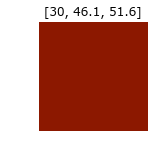

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from colour import Lab_to_XYZ,XYZ_to_sRGB

def lab_to_srgb(lab):# LabからsRGBに変換
    xyz=Lab_to_XYZ(lab);srgb=XYZ_to_sRGB(xyz)
    srgb=np.clip(srgb,0,1);return srgb

def show_swatch(lab):# 1ピクセル画像を表示
    srgb=lab_to_srgb(lab) # Lab⇒sRGB
    plt.figure(figsize=(2,2))
    plt.imshow([[srgb]]);plt.axis('off')
    plt.title(f"{lab}");plt.show()

labs={46:[76.7,12.5,81.9],# 標準色46番
      22:[36.7,45.6,62.9],# 標準色22番
      18:[30,  46.1,51.6]}# 標準色18番 
for lab in labs.values():
    show_swatch(lab)  # 色スウォッチ表示

## 地方の平均醤油色で醤油日本地図を描くコード

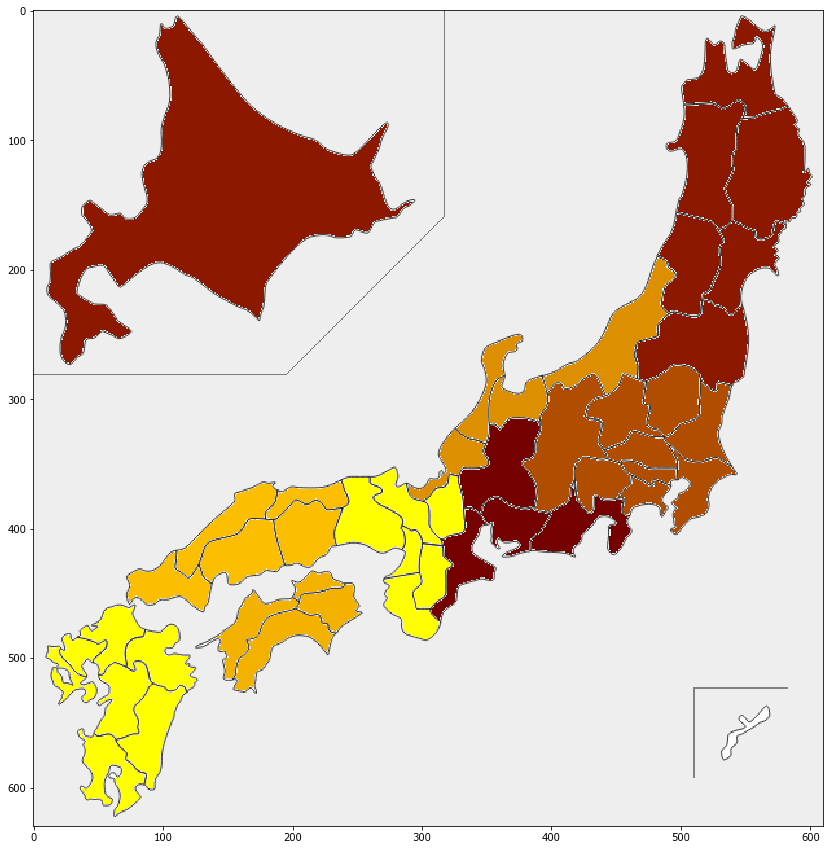

In [13]:
import matplotlib.pyplot as plt
from japanmap import picture

plt.rcParams["figure.figsize"]=15,15

def ratio_to_srgb(ratio):
    ratio=(ratio/100)*6 #色識別用に強調
    l18=lab_to_srgb(labs[18])*(1-ratio)
    l46=lab_to_srgb(labs[46])*ratio
    return tuple(l18*255+l46*255)

l={};l[1]=ratio_to_srgb(0)# 北海道
for i in range(2,8):      # 東北
    l[i]=ratio_to_srgb(0)
for i in list(range(8,15))+[19,20]:
    l[i]=ratio_to_srgb(5.8)# 関東甲信越
for i in [15,16,17,18]:   # 北陸   
    l[i]=ratio_to_srgb(12.9)
for i in range(21,25):  # 中部(含む静岡)
    # 溜まり醤油利用は濃くなる方向に演算
    l[i]=ratio_to_srgb(5.5+3.8-13.0)
for i in range(25,31):    # 近畿
    l[i]=ratio_to_srgb(31.5)
for i in range(31,36):    # 中国
    l[i]=ratio_to_srgb(18.0)
for i in range(36,40):    # 四国
    l[i]=ratio_to_srgb(16.6)
for i in range(40,47):    # 九州
    l[i]=ratio_to_srgb(26.0)
plt.imshow(picture(l))

# plt.savefig('map.png')  # save to PNG file


## 食品の含有成分と味覚受容体を刺激成分の対応から、 4 味を算出するコード

In [25]:
import pandas as pd

def read_from_mext_excel(path,sheet_name,skiprows,skiprows_from_data):
    df=pd.read_excel(path,        # ファイルパス
        sheet_name=sheet_name,    # 読み込み元シート
        skiprows=range(skiprows), # ラベル行の前にある行数
        header=0)                 # ラベル行の指定
    # 「ラベル行とデータ行間の行数」に応じた行を削除する、
    return df.drop(df.index[range(skiprows_from_data)])

def build_taste_from_df_and_elements_and_ratios(df,name,elements):
    filtered_df=df[df['成分識別子'].str.contains(name)]
    if filtered_df.shape[0]>0:
        taste=0.0
        for key,value in elements.items():
            s=str(filtered_df[key].iloc[0]).\
replace('-','0.0').replace('Tr','0.0').replace('(','').replace(')','')
            taste+=float(s)*value
    else:
        taste=float('NaN')
    return taste
    
def build_basic_taste_from_sheet_and_name(sheet,name,name_order):
    taste={}
    df=read_from_mext_excel( # 「塩味」の読み込み
        "./mext/20230428-mxt_kagsei-mext_00001_012.xlsx",sheet,11,0)
    val=build_taste_from_df_and_elements_and_ratios(df,name,
        {'NACL_EQ':1.0}) # 食塩相当量 
    taste['塩味']=val
    df=read_from_mext_excel( # 「うま味」の読み込み(アミノ酸成分表)
        "./mext/20230428-mxt_kagsei-mext_00001_022.xlsx",sheet,4,1)
    val=build_taste_from_df_and_elements_and_ratios(df,name,
        # グルタミン酸,アスパラギン酸,アラニン,グリシン
        {'GLU ':1.0,'ASP':1.0,'ALA ':1.0,'GLY':1.0})
    taste['うま味']=val
    df=read_from_mext_excel( # 「甘味」の読み込み(炭水化物_第2章本表)
        "./mext/20230428-mxt_kagsei-mext_00001_042.xlsx",sheet,4,1)
    # ぶどう糖(g/100g),果糖(g/100g),しょ糖(g/100g),麦芽糖(g/100g)
    val=build_taste_from_df_and_elements_and_ratios(df,name,
        {'GLUS':1.0,'FRUS':1.0,'SUCS':1.0,'MALS':1.0}) 
    taste['甘味']=val
    df=read_from_mext_excel(#「酸味」の読み込み(炭水化物 第2章本表別表2)
        "./mext/20230428-mxt_kagsei-mext_00001_044.xlsx",sheet,4,1)
    val=build_taste_from_df_and_elements_and_ratios(df,name,
    # 酢酸(g/100g),リンゴ酸(g/100g),酒石酸(g/100g),クエン酸麦芽糖(g/100g)
        {'ACEAC':1.0,'MALAC':1.0,'TARAC':1.0,'CITAC':1.0})
    taste['酸味']=val
    if type(name_order) is int:
        return {'name':name.split()[name_order],'taste':taste}
    else:
        return {'name':name_order,'taste':taste}

In [26]:
taste=build_basic_taste_from_sheet_and_name(
'17調味料及び香辛料類','＜調味料類＞　（しょうゆ類）　こいくちしょうゆ',-1)
print(taste)

{'name': 'こいくちしょうゆ', 'taste': {'塩味': 14.5, 'うま味': 3110.0, '甘味': 1.1, '酸味': 0.2}}


## 味をレーダーチャートに表示する関数

In [24]:
plt.rcParams['font.family'] = 'Hiragino Sans'# フォント設定
plt.rcParams['font.weight'] = 'bold'         # 太さ

def make_rader_chart(tastes,ratios):
    labels=list(tastes[0]['taste'].keys())
    angles=np.concatenate((np.linspace(0,2*np.pi,len(labels),endpoint=False),[angles[0]]))
    fig=plt.figure();ax=fig.add_subplot(111,polar=True);ax.set_ylim(0,20)
    ax.set_thetagrids(angles[:-1]*180/np.pi,labels,fontsize=16)
    for taste in tastes:
        values=[value*ratios[i] for i, value in enumerate(list(taste['taste'].values()))]
        values+=values[:1]; ax.fill(angles,values,alpha=0.15)
        ax.plot(angles,values,'o-',linewidth=2,label=taste['name'])
    legend_properties = {'size':14,'weight':'bold'}
    ax.legend(loc="center left",bbox_to_anchor=(1.2,0.5,),borderaxespad=0,prop=legend_properties)
    return plt.show()

In [22]:
category='17調味料及び香辛料類'
sauces=[build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　たまりしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　さいしこみしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　こいくちしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　うすくちしょうゆ',-1),
        build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　しろしょうゆ',-1)]
print(sauces)

[{'name': 'たまりしょうゆ', 'taste': {'塩味': 13.0, 'うま味': 5200.0, '甘味': nan, '酸味': nan}}, {'name': 'さいしこみしょうゆ', 'taste': {'塩味': 12.4, 'うま味': 3900.0, '甘味': 1.4, '酸味': 0.30000000000000004}}, {'name': 'こいくちしょうゆ', 'taste': {'塩味': 14.5, 'うま味': 3110.0, '甘味': 1.1, '酸味': 0.2}}, {'name': 'うすくちしょうゆ', 'taste': {'塩味': 16.0, 'うま味': 2460.0, '甘味': 2.1999999999999997, '酸味': 0.2}}, {'name': 'しろしょうゆ', 'taste': {'塩味': 14.2, 'うま味': 1000.0, '甘味': 1.4, '酸味': 0.30000000000000004}}]


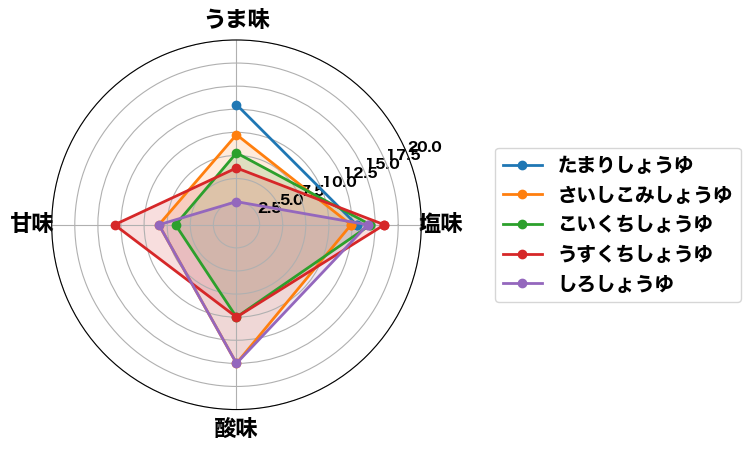

In [23]:
make_rader_chart(sauces,[1,1/400,6,50])

In [9]:
category='10魚介類'
tastes=[
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（あじ類）　まあじ　皮なし　生',-3),
#build_basic_taste_from_sheet_and_name(category,
#         '＜魚類＞　（さけ・ます類）　からふとます　生',-2),
    build_basic_taste_from_sheet_and_name(category,
         '＜えび・かに類＞　（えび類）　あまえび　生',-2),
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（まぐろ類）　くろまぐろ　天然　赤身　生',-4),   
    build_basic_taste_from_sheet_and_name(category,
         '＜えび・かに類＞　（えび類）　あまえび　生',-2),
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　ひらめ　天然　生',-3),
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（たい類）　まだい　天然　生',-3),
    
    #build_basic_taste_from_sheet_and_name(category,
    #     '＜魚類＞　（かつお類）　かつお　春獲り　生','かつお　春獲り'),    
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（かつお類）　かつお　秋獲り　生','かつお　秋獲り'),    
]
print(tastes)

[{'name': 'まあじ', 'taste': {'塩味': 0.3, 'うま味': 6820.0, '甘味': nan, '酸味': nan}}, {'name': 'あまえび', 'taste': {'塩味': 0.8, 'うま味': 7100.0, '甘味': nan, '酸味': nan}}, {'name': 'くろまぐろ', 'taste': {'塩味': 0.1, 'うま味': 8500.0, '甘味': nan, '酸味': nan}}, {'name': 'あまえび', 'taste': {'塩味': 0.8, 'うま味': 7100.0, '甘味': nan, '酸味': nan}}, {'name': 'ひらめ', 'taste': {'塩味': 0.1, 'うま味': 7600.0, '甘味': nan, '酸味': nan}}, {'name': 'まだい', 'taste': {'塩味': 0.1, 'うま味': 7380.0, '甘味': nan, '酸味': nan}}, {'name': 'かつお\u3000秋獲り', 'taste': {'塩味': 0.1, 'うま味': 7700.0, '甘味': nan, '酸味': nan}}]


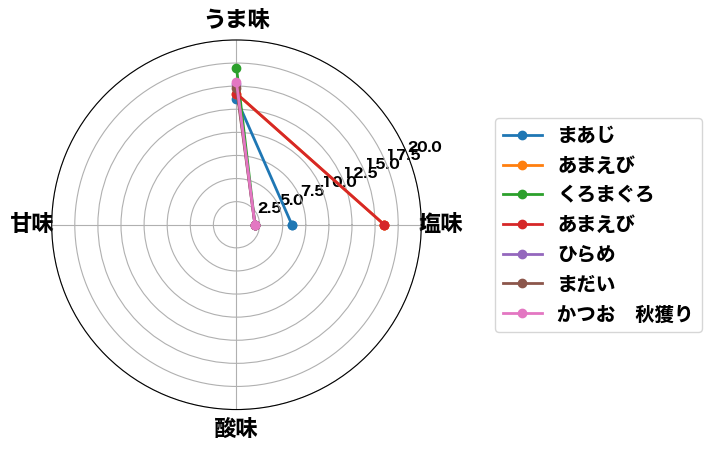

In [10]:
make_rader_chart(tastes,
                [20,1/500,1,50])

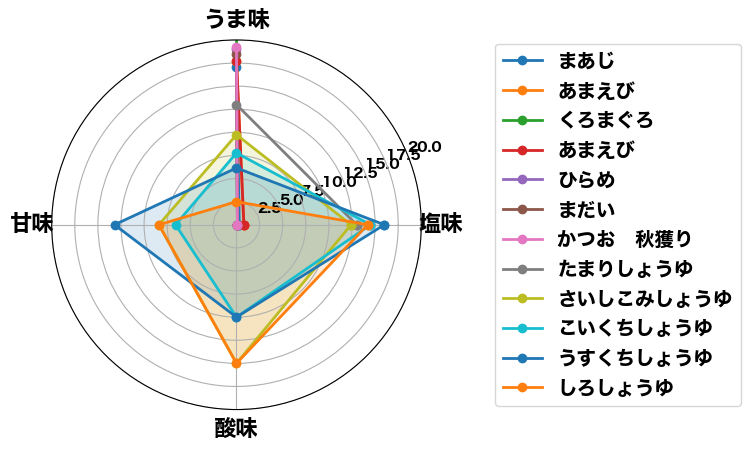

In [19]:
#make_rader_chart(tastes+sauces,
#                [1,1/500,1,50])
make_rader_chart(tastes+sauces,
                [1,1/400,6,50])

## 以下はさまざまな4味レーダーチャートの表示例

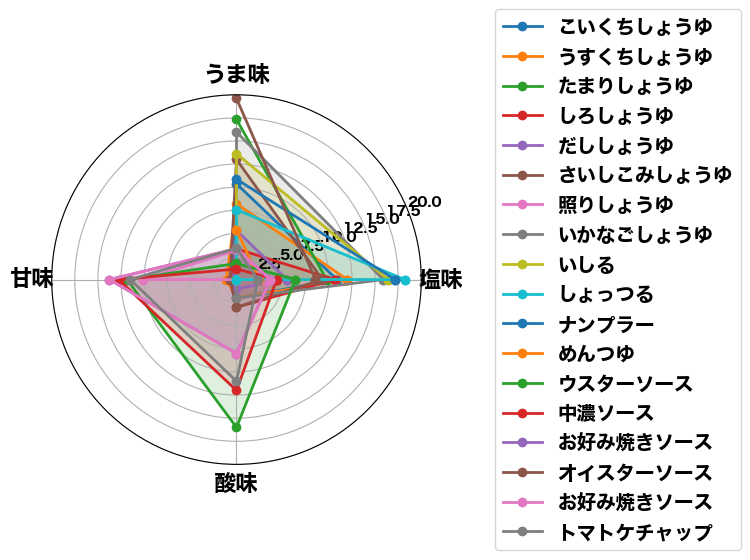

In [14]:
make_rader_chart(tastes,
                [0.75,1/300,1/2,10])

In [15]:
category='10魚介類'
tastes=[
    
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（あじ類）　まあじ　皮なし　生',-3),
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（さけ・ます類）　からふとます　生',-2),
    build_basic_taste_from_sheet_and_name(category,
         '＜えび・かに類＞　（えび類）　あまえび　生',-2),
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（まぐろ類）　くろまぐろ　天然　赤身　生',-4),    
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（かつお類）　かつお　春獲り　生',-3),    
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　（かつお類）　かつお　秋獲り　生',-3),    
      
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　あいなめ　生',-2),  
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　あまだい　生',-2),    
    build_basic_taste_from_sheet_and_name(category,
         '＜魚類＞　ひらめ　天然　生',-3),

]
category='17調味料及び香辛料類'
sauces=[
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　こいくちしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　うすくちしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　たまりしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　しろしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　だししょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　さいしこみしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　照りしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（しょうゆ類）　照りしょうゆ',-1),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（ドレッシング類）　半固形状ドレッシング　マヨネーズ　全卵型',-2),
    build_basic_taste_from_sheet_and_name(category,
         '＜調味料類＞　（調味ソース類）　ぽん酢しょうゆ',-1),
    
]
print(tastes+sauces)

[{'name': 'まあじ', 'taste': {'塩味': 0.3, 'うま味': 6820.0, '甘味': nan, '酸味': nan}}, {'name': 'からふとます', 'taste': {'塩味': 0.2, 'うま味': 7700.0, '甘味': nan, '酸味': nan}}, {'name': 'あまえび', 'taste': {'塩味': 0.8, 'うま味': 7100.0, '甘味': nan, '酸味': nan}}, {'name': 'くろまぐろ', 'taste': {'塩味': 0.1, 'うま味': 8500.0, '甘味': nan, '酸味': nan}}, {'name': 'かつお', 'taste': {'塩味': 0.1, 'うま味': 7700.0, '甘味': nan, '酸味': nan}}, {'name': 'かつお', 'taste': {'塩味': 0.1, 'うま味': 7700.0, '甘味': nan, '酸味': nan}}, {'name': 'あいなめ', 'taste': {'塩味': 0.4, 'うま味': 6790.0, '甘味': nan, '酸味': nan}}, {'name': 'あまだい', 'taste': {'塩味': 0.2, 'うま味': 6800.0, '甘味': nan, '酸味': nan}}, {'name': 'ひらめ', 'taste': {'塩味': 0.1, 'うま味': 7600.0, '甘味': nan, '酸味': nan}}, {'name': 'こいくちしょうゆ', 'taste': {'塩味': 14.5, 'うま味': 3110.0, '甘味': 1.1, '酸味': 0.2}}, {'name': 'うすくちしょうゆ', 'taste': {'塩味': 16.0, 'うま味': 2460.0, '甘味': 2.1999999999999997, '酸味': 0.2}}, {'name': 'たまりしょうゆ', 'taste': {'塩味': 13.0, 'うま味': 5200.0, '甘味': nan, '酸味': nan}}, {'name': 'しろしょうゆ', 'taste': {'塩味': 14.2, 'うま味':

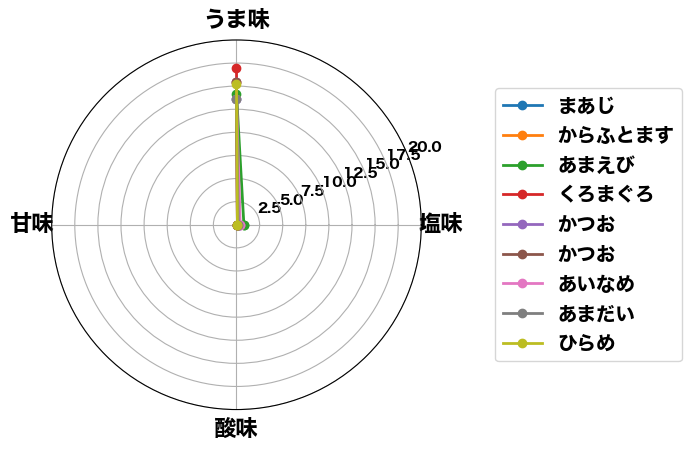

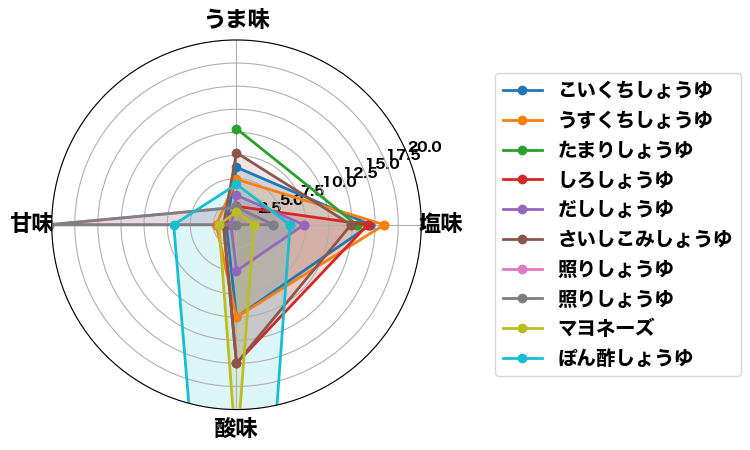

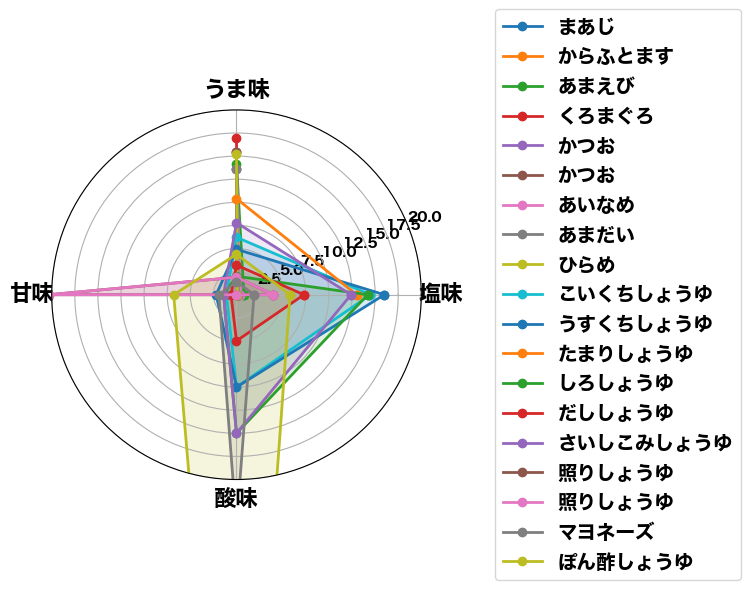

In [16]:
make_rader_chart(tastes,
                [1,1/500,1,50])
make_rader_chart(sauces,
                [1,1/500,1,50])
make_rader_chart(tastes+sauces,
                [1,1/500,1,50])